**<span style="color: gray;">In The Name of God</span>**

---

Erfan Falahati

SID: 810102491


In [320]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

RATING_DATASET_PATH = 'content/q3_dataset/train_data_movie_rate.csv'
TRUST_DATASET_PATH = 'content/q3_dataset/train_data_movie_trust.csv'


rating_dataset = pd.read_csv(RATING_DATASET_PATH)
trust_dataset = pd.read_csv(TRUST_DATASET_PATH)

# ***<span style="color: #f3ce13;">Data Exploration</span>***

## ***<span style="color: #C0C0C0;">🎞  Movie Rating Data Exploration</span>***

In [321]:
from IPython.display import display, Markdown

display(rating_dataset.head().style.set_table_attributes('style="display:inline"'))

,id,user_id,item_id,label
0,1,1,1,2.000000
1,2,1,2,4.000000
2,3,1,3,3.500000
3,4,1,4,3.000000
4,5,1,5,4.000000


### ***<span style="color: #0080FF;">Data Description</span>***

In [322]:
display(rating_dataset.describe().style.set_table_attributes('style="display:inline"'))

,id,user_id,item_id,label
count,34298.000000,34298.000000,34298.000000,34298.000000
mean,17149.500000,764.002303,266.193452,3.006298
std,9901.124103,427.022738,349.849377,0.915706
min,1.000000,1.000000,1.000000,0.500000
25%,8575.250000,398.000000,12.000000,2.500000
50%,17149.500000,761.000000,216.000000,3.000000
75%,25723.750000,1142.000000,251.000000,4.000000
max,34298.000000,1508.000000,2071.000000,4.000000


### ***<span style="color: #0080FF;">Check For The NULL Values</span>***

In [323]:
display(rating_dataset.isnull().sum())

id         0
user_id    0
item_id    0
label      0
dtype: int64

<Axes: >

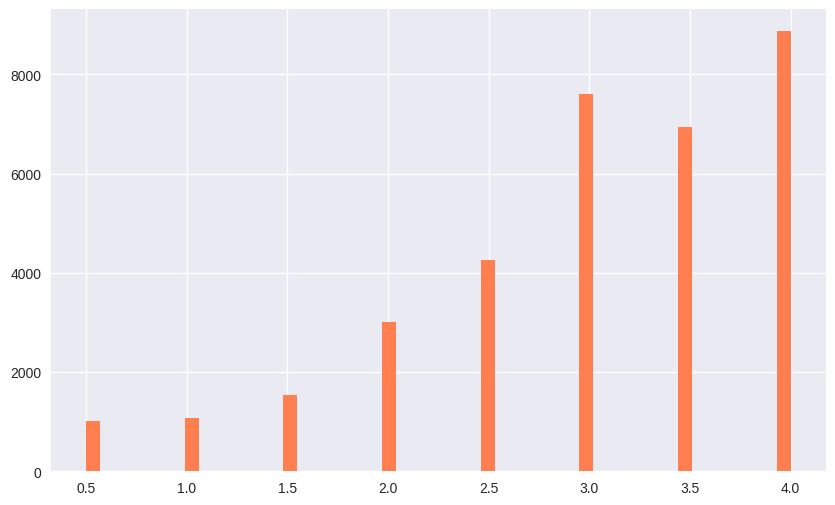

In [324]:
rating_dataset['label'].hist(bins=50, figsize=(10,6), color='coral')

## ***<span style="color: #C0C0C0;">🌐 User Trust Data Exploration</span>***

In [325]:
display(trust_dataset.head(10).style.set_table_attributes('style="display:inline"'))

,id,user_id_trustor,user_id_trustee,trust_value
0,1,2,966,1
1,2,2,104,1
2,3,5,1509,1
3,4,6,1192,1
4,5,7,1510,1
5,6,12,234,1
6,7,15,652,1
7,8,15,883,1
8,9,15,1511,1
9,10,15,1512,1


### ***<span style="color: #0080FF;">Data Description</span>***

In [326]:
display(trust_dataset.describe().style.set_table_attributes('style="display:inline"'))

,id,user_id_trustor,user_id_trustee,trust_value
count,1853.000000,1853.000000,1853.000000,1853.000000
mean,927.000000,775.437669,782.192121,1.000000
std,535.059343,447.736536,471.614626,0.000000
min,1.000000,2.000000,2.000000,1.000000
25%,464.000000,410.000000,395.000000,1.000000
50%,927.000000,752.000000,716.000000,1.000000
75%,1390.000000,1160.000000,1187.000000,1.000000
max,1853.000000,1641.000000,1642.000000,1.000000


### ***<span style="color: #0080FF;">Check Fo The NULL Values</span>***

In [327]:
display(trust_dataset.isnull().sum())

id                 0
user_id_trustor    0
user_id_trustee    0
trust_value        0
dtype: int64

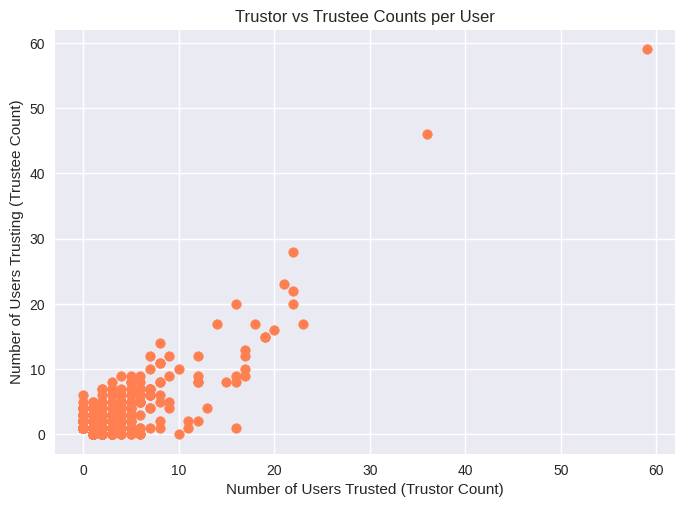

In [328]:
trustor_counts = trust_dataset.groupby("user_id_trustor").size()
trustee_counts = trust_dataset.groupby("user_id_trustee").size()

user_trust_counts = pd.DataFrame({
    "trusts_others": trustor_counts,
    "trusted_by_others": trustee_counts
}).fillna(0)  

plt.scatter(user_trust_counts["trusts_others"], user_trust_counts["trusted_by_others"], color='coral')
plt.xlabel("Number of Users Trusted (Trustor Count)")
plt.ylabel("Number of Users Trusting (Trustee Count)")
plt.title("Trustor vs Trustee Counts per User")
plt.grid(True)
plt.show()


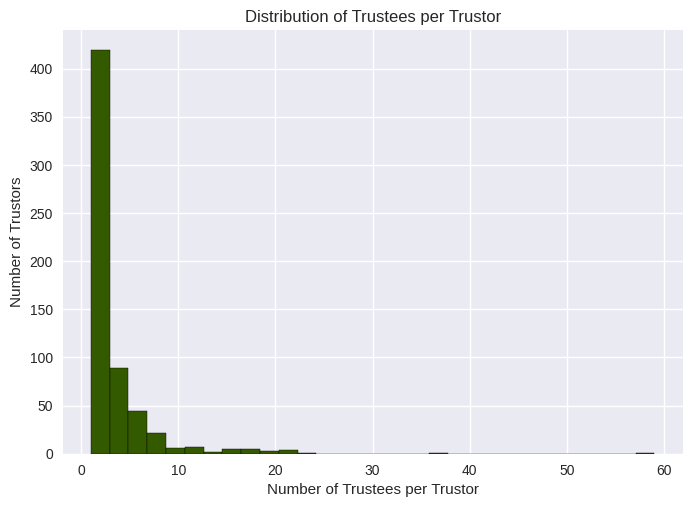

In [329]:
import matplotlib.pyplot as plt

trusts_per_trustor = trust_dataset.groupby("user_id_trustor").size()

plt.hist(trusts_per_trustor, bins=30, edgecolor='black', color='#345a00')
plt.xlabel("Number of Trustees per Trustor")
plt.ylabel("Number of Trustors")
plt.title("Distribution of Trustees per Trustor")
plt.grid(True)
plt.show()


# ***<span style="color: #f3ce13;">Preprocess</span>***




## ***<span style="color: #0080FF;">It has been done in the [core.py](core.py) file.</span>***

# ***<span style="color: #f3ce13;">Model</span>***

In [330]:
RATING_DATA_PATH = 'content/q3_dataset/train_data_movie_rate.csv'
TRUST_DATA_PATH = 'content/q3_dataset/train_data_movie_trust.csv'
TEST_DATA_PATH = 'content/q3_dataset/test_data.csv'
MODEL_CONFIG_PATH = 'content/q3_dataset/config.json'
SUBMISSION_PATH = 'content/q3_dataset/submission.csv'

epoch_count = 12

## ***<span style="color: #0080FF;">Step 1: Load and preprocess data</span>***

In [331]:
from core import GlotMF, GlotMFPreprocessor

prep = GlotMFPreprocessor(RATING_DATA_PATH, TRUST_DATA_PATH)
ratings_df, trust_df = prep.load_data()
reputation_weights = prep.compute_pagerank()
trust_neighbors = prep.build_trust_neighbors()
trust_neighbors = {u: vs for u, vs in trust_neighbors.items() if len(vs) >= 2}

# Users: 1642, # Items: 2071


## ***<span style="color: #0080FF;">Step 2: Grid Search (find the best config)</span>***

In [332]:
from tools import evaluate_model
import itertools
import json
import os

if os.path.exists(MODEL_CONFIG_PATH):
    with open(MODEL_CONFIG_PATH, 'r') as f:
        best_config = json.load(f)
else:
    K_values = [10, 20]
    alpha_values = [0.4, 0.6, 0.8]
    lr_values = [0.005, 0.01]

    best_mae = float('inf')
    best_config = None

    for K, alpha, lr in itertools.product(K_values, alpha_values, lr_values):
        print(f"\n🔍 Testing K={K}, alpha={alpha}, lr={lr}")
        model = GlotMF(num_users=prep.num_users, num_items=prep.num_items,
                        K=K, alpha=alpha, lr=lr,
                        lambda_reg=0.001, lambda_B=0.1, lambda_E=0.1)

        model.train(ratings_df, reputation_weights,
                    prep.user_id_to_idx, prep.item_id_to_idx, trust_neighbors, epochs=epoch_count)

        mae, rmse, mse, r2 = evaluate_model(model, ratings_df, prep.user_id_to_idx, prep.item_id_to_idx)
        print(f"✅ MAE: {mae:.4f}, RMSE: {rmse:.4f}, MSE: {mse}, R2: {r2}")

        if mae < best_mae:
            best_mae = mae
            best_config = {'K': K, 'alpha': alpha, 'lr': lr}
        
    with open(MODEL_CONFIG_PATH, 'w') as f:
        json.dump(best_config, f, indent=4)
   
    print(f"\n🏆 Best config: K={best_config['K']}, alpha={best_config['alpha']}, lr={best_config['lr']} — MAE={best_mae:.4f}")


🔍 Testing K=10, alpha=0.4, lr=0.005
Epoch 1 MAE: 0.6827 RMSE: 0.8585, MSE 0.7370654269861929, R2: 0.12096433317016564
Epoch 2 MAE: 0.6611 RMSE: 0.8314, MSE 0.691153074062578, R2: 0.17572011778613927
Epoch 3 MAE: 0.6454 RMSE: 0.8136, MSE 0.6618908193666073, R2: 0.21061873686096777
Epoch 4 MAE: 0.6339 RMSE: 0.8012, MSE 0.6419976501290547, R2: 0.2343436392181344
Epoch 5 MAE: 0.6251 RMSE: 0.7923, MSE 0.6277822844751102, R2: 0.25129710490698043
Epoch 6 MAE: 0.6182 RMSE: 0.7856, MSE 0.6171649927304415, R2: 0.2639594518126869
Epoch 7 MAE: 0.6127 RMSE: 0.7803, MSE 0.6089113232272596, R2: 0.2738029061518611
Epoch 8 MAE: 0.6082 RMSE: 0.7761, MSE 0.6022600767550803, R2: 0.2817352859160679
Epoch 9 MAE: 0.6044 RMSE: 0.7725, MSE 0.5967266988939338, R2: 0.2883344782264208
Epoch 10 MAE: 0.6012 RMSE: 0.7694, MSE 0.591993955606814, R2: 0.2939788213186465
Epoch 11 MAE: 0.5985 RMSE: 0.7667, MSE 0.5878488487263724, R2: 0.29892234011266816
Epoch 12 MAE: 0.5960 RMSE: 0.7643, MSE 0.5841450910641494, R2: 0.30

## ***<span style="color: #0080FF;">Step 3: Initialize and train model</span>***

In [333]:
model = GlotMF(num_users=prep.num_users, num_items=prep.num_items,
                   K=best_config['K'], alpha=best_config['alpha'], lr=best_config['lr'],
                   lambda_reg=0.001, lambda_B=0.1, lambda_E=0.1)
    
model.train(ratings_df, reputation_weights,
            prep.user_id_to_idx, prep.item_id_to_idx, trust_neighbors, epochs=epoch_count)

Epoch 1 MAE: 0.6601 RMSE: 0.8298, MSE 0.6885635757330747, R2: 0.1788083936806376
Epoch 2 MAE: 0.6306 RMSE: 0.7971, MSE 0.6352937413899458, R2: 0.2423388248191536
Epoch 3 MAE: 0.6129 RMSE: 0.7792, MSE 0.6071687207546643, R2: 0.27588116090433346
Epoch 4 MAE: 0.6009 RMSE: 0.7674, MSE 0.5889197110051726, R2: 0.2976452131401318
Epoch 5 MAE: 0.5917 RMSE: 0.7581, MSE 0.5747597316536612, R2: 0.3145326242651495
Epoch 6 MAE: 0.5839 RMSE: 0.7498, MSE 0.562194282468088, R2: 0.32951837396856587
Epoch 7 MAE: 0.5767 RMSE: 0.7416, MSE 0.5500326092401872, R2: 0.3440225741986149
Epoch 8 MAE: 0.5694 RMSE: 0.7333, MSE 0.5376797855582671, R2: 0.35875474342661384
Epoch 9 MAE: 0.5620 RMSE: 0.7245, MSE 0.524869814140963, R2: 0.3740321141383621
Epoch 10 MAE: 0.5543 RMSE: 0.7152, MSE 0.5115545392497698, R2: 0.38991211761493516
Epoch 11 MAE: 0.5463 RMSE: 0.7056, MSE 0.4978408222992561, R2: 0.4062673092749236
Epoch 12 MAE: 0.5380 RMSE: 0.6957, MSE 0.4839353777020917, R2: 0.4228511583017518


## ***<span style="color: #0080FF;">Step 4: Evaluate</span>***

In [334]:
mae, rmse, mse, r2 = evaluate_model(model, ratings_df, prep.user_id_to_idx, prep.item_id_to_idx)
print(f"Final MAE: {mae:.4f}, RMSE: {rmse:.4f}, MSE: {mse}, R2: {r2}")

Final MAE: 0.5380, RMSE: 0.6957, MSE: 0.4839353777020917, R2: 0.4228511583017518


## ***<span style="color: #0080FF;">Step 5: Generate Submission</span>***

In [335]:
from tools import generate_submission

test_data = pd.read_csv(TEST_DATA_PATH)
generate_submission(model, test_data, prep.user_id_to_idx, prep.item_id_to_idx, SUBMISSION_PATH)

✅ Submission saved to 'content/q3_dataset/submission.csv'


# ***<span style="color: #f3ce13;">Validation</span>***

In [336]:
from sklearn.model_selection import train_test_split

model = GlotMF(num_users=prep.num_users, num_items=prep.num_items,
                K=best_config['K'], alpha=best_config['alpha'], lr=best_config['lr'],
                lambda_reg=0.01, lambda_B=0.1, lambda_E=0.1)

train_df, val_df = train_test_split(ratings_df, test_size=0.2, random_state=491)

model.train(train_df, reputation_weights,
            prep.user_id_to_idx, prep.item_id_to_idx, trust_neighbors, epochs=epoch_count)

mae_train, rmse_train, mse_train, r2_train = evaluate_model(model, train_df, prep.user_id_to_idx, prep.item_id_to_idx)
mae_val, rmse_val, mse_val, r2_val = evaluate_model(model, val_df, prep.user_id_to_idx, prep.item_id_to_idx)
print(f"Train MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, MSE: {mse_train}, R2: {r2_train}")
print(f"Validation MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}, MSE: {mse_val}, R2: {r2_val}")


Epoch 1 MAE: 0.6673 RMSE: 0.8374, MSE 0.7012391182867205, R2: 0.16101808663166728
Epoch 2 MAE: 0.6386 RMSE: 0.8045, MSE 0.647201239931326, R2: 0.22567050175611414
Epoch 3 MAE: 0.6202 RMSE: 0.7853, MSE 0.6166832376776638, R2: 0.2621830853460212
Epoch 4 MAE: 0.6076 RMSE: 0.7726, MSE 0.59685446502554, R2: 0.28590677842816103
Epoch 5 MAE: 0.5981 RMSE: 0.7631, MSE 0.5822492855169668, R2: 0.3033808199207815
Epoch 6 MAE: 0.5905 RMSE: 0.7552, MSE 0.5703051028722724, R2: 0.31767117102576514
Epoch 7 MAE: 0.5839 RMSE: 0.7481, MSE 0.5597280663291403, R2: 0.3303258306494393
Epoch 8 MAE: 0.5778 RMSE: 0.7415, MSE 0.5498270859996623, R2: 0.3421716378846985
Epoch 9 MAE: 0.5722 RMSE: 0.7350, MSE 0.5402231389932843, R2: 0.35366206622102037
Epoch 10 MAE: 0.5666 RMSE: 0.7285, MSE 0.5307142443847572, R2: 0.36503877123452744
Epoch 11 MAE: 0.5610 RMSE: 0.7219, MSE 0.5212074804516318, R2: 0.37641292704894036
Epoch 12 MAE: 0.5555 RMSE: 0.7153, MSE 0.5116803832077843, R2: 0.3878114101997636
Train MAE: 0.5555, RM